# Peaks-over-threshold (POT) vs máximos anuales
***

_Autor:_    __Jesús Casado__ <br> _Revisión:_ __06/03/2020__ <br>

__Introducción__<br>
Se hace un análisis de extremos por dos métodos (máximos anuales y POT) para un caso de ejemplo en el río Paraguay en Asunción.

__Cosas que arreglar__ <br>
En el método POT, la distribución discreta puede ser una Poisson, una binomial o una binomial negativa. Por ahora sólo está montado con la Poisson. Igualmente, la distribución continua puede ser una exponencial o una pareto generalizada; por ahora sólo está montado con la exponencial.

__Índice__ <br>

__[Cargar datos](#Cargar-datos)__ <br>

__[Serie de máximos anuales](#Serie-de-máximos-anuales)__ <br>

__[Peak over threshold](#Peak-over-threshold)__<br>
[Selección de eventos](#Selección-de-eventos)<br>
[Distribución del número anual de eventos](#Distribución-del-número-anual-de-eventos)<br>
[Distribución de la magnitud de los eventos](#Distribución-de-la-magnitud-de-los-eventos)<br>
[Definición de la distribución mixta (Poisson + exponenecial)](#Definición-de-la-distribución-mixta-(Poisson-+-exponenecial))<br>
[Aplicación al ejemplo](#Aplicación-al-ejemplo)<br>

In [1]:
%run funciones_POT.ipynb

## Cargar datos
Se cargan los datos del ejemplo, una serie diaria de nivel del río en la ciudad de Asunción (Paraguay). Para hacer un mínimo análisis visual de la tendencia de la serie, se calculan las medias móviles centrada anual y decadal.

In [2]:
# impotar datos
N = pd.read_excel(rutaBase + '../data/Alturas_Py_Asu_1904_2019.xlsx',
                  sheet_name='niveles', usecols=[0,1], index_col=0, parse_dates=True)
N.columns = ['N_m']
N = pd.Series(N.iloc[:,0])

In [3]:
# media móvil
N1y = N.rolling(365, center=True).mean()
N10y = N.rolling(365 * 10, center=True).mean()

C:\Anaconda3\envs\test\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


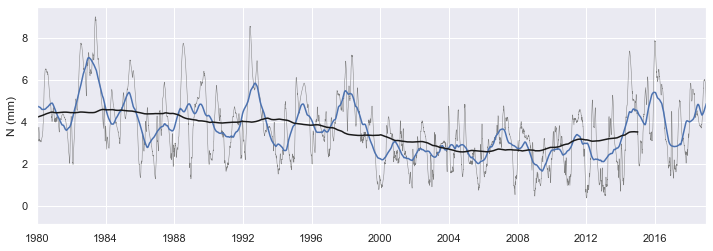

In [4]:
plt.figure(figsize=(12, 4))
plt.plot(N.index, N, 'gray', lw=.5)
plt.plot(N1y.index, N1y)
plt.plot(N10y.index, N10y, 'k')
# plt.xlim(N.index[0], N.index[-1])
plt.xlim('1980', '2019')
plt.ylabel('N (mm)');

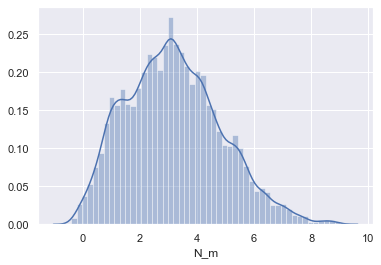

In [5]:
sns.distplot(N);

## Serie de máximos anuales
En la práctica habitual del análisis de extremos, se genera una serie anual con el máximo observado de dicha variable en cada año. Sobre esta serie anual se busca la distribución de extremos (GEV, Weibull, Frechet, Gumbel,...) que mejor se ajuste.

Una vez ajustada la función de distribución, se pueden trazar las funciones de densidad (`pdf`) y distribución acumulada (`cdf`), así como calcular el cuantil para una probabilidad de no-excedencia dada (`ppf`).

In [6]:
# serie de máximos anuales
Nma = N.groupby(N.index.year).max()

Fitted frechet_r distribution with error=1.657191642856036)
Fitted genextreme distribution with error=1.6362543254078201)
Fitted gumbel_r distribution with error=1.6848161792463234)
Fitted norm distribution with error=1.6492894205087025)
Fitted weibull_max distribution with error=1.6362484686732486)


,sumsquare_error,aic,bic,kl_div
weibull_max,1.636248,477.258702,-480.036584,inf
genextreme,1.636254,477.256521,-480.036169,inf
norm,1.649289,478.062300,-483.869315,inf
frechet_r,1.657192,473.303129,-478.561263,inf
gumbel_r,1.684816,486.142709,-481.397132,inf


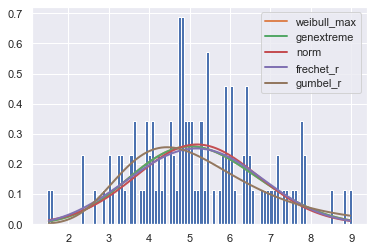

In [7]:
# buscar distribución con mejor rendimiento
distributions = ['frechet_r', 'genextreme', 'gumbel_r', 'norm', 'weibull_max']
F = Fitter(Nma, distributions=distributions)
F.fit()
F.summary()

In [8]:
# seleccionar la mejor distribución y sus parámetros
print(F.get_best())
# nombre de la mejor distribución
distStr = list(F.get_best().keys())[0]
# 'callable' de la distribución
distFunc = DFdict[distStr]
# parámetros ajustados
pars = F.get_best()[distStr]

{'weibull_max': (4.1477477935683105, 10.71687765588435, 6.091300585196433)}


In [9]:
# cdf y pdf de la distribución analítica
x = np.linspace(0, 12, 101)
cdf = distFunc.cdf(x, *pars)
pdf = distFunc.pdf(x, *pars)

In [10]:
# cdf de la distribución empírica
ecdf = ECDF(Nma)
qs = ecdf(Nma)

In [28]:
# valor para un retorno de 100 años-> cdf = 0.99
Tr = 100
N100_ma = distFunc.ppf(1 - 1 / Tr, *pars)
print('N(Tr=100) = {0:.2f} m'.format(N100_ma))

N(Tr=100) = 8.71 m


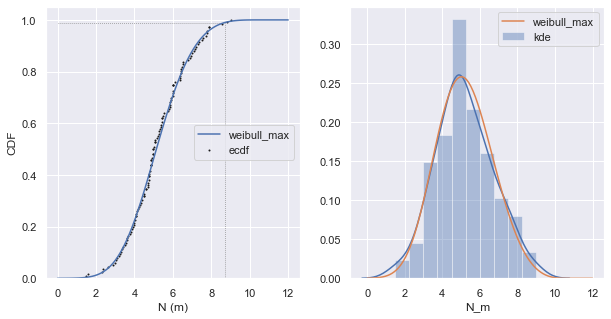

In [12]:
# gráfico de comparación
fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0].scatter(Nma, qs, s=1, c='k', label='ecdf')
ax[0].plot(x, cdf, label=distStr)
ax[0].hlines(.99, 0, N100_ma, lw=.75, ls=':', color='gray')
ax[0].vlines(N100_ma, 0, .99, lw=.75, ls=':', color='gray')
ax[0].set(ylim=(0), ylabel='CDF', xlabel='N (m)')
ax[0].legend(loc=7);

sns.distplot(Nma, kde=True, ax=ax[1], label='kde')
# sns.kdeplot(Nma, shade=True, ax=ax[1], label='kde')
plt.plot(x, pdf, label=distStr)
ax[1].legend();

## Peak over threshold (POT)

__Referencias__
[(Bezak et al., 2014. Hydrological Sciences Journal)](https://www.tandfonline.com/doi/full/10.1080/02626667.2013.831174)<br>
[(Lang et al., 1999. Journal of Hydrology)](https://www.sciencedirect.com/science/article/pii/S0022169499001675)<br>
https://ethz.ch/content/dam/ethz/special-interest/baug/ifu/hydrology-dam/documents/lectures/hydrologie/lectures/HYI_HS17_Transp_09_FEM.pdf

En el análisis de extremos mediante POT se escogen eventos de manera distinta. En vez de escoger un evento máximo anual, se escogen eventos que superan un umbral; estos eventos han de ser indipendientes, eso sí. Esto permite es tener un mayor número de eventos extremos para el análisis, de manera que el análisis posterior sea más robusto. El inconiente es que se incumple la hipótesis de recurrencia anual de los eventos extremos, con lo que no se pueden aplicar las funciones de distribución de extremos habituales (GEV, Gumbel, Weibull...).

El proceso tiene cuatro pasos:
1.  Selección de los eventos considerados extremos.
2.  Ajuste de la distribución discreta que define cuántos eventos ocurren por año.
3.  Ajuste de la distribución continua que define la magnitud de dichos eventos.
4.  Cálculo de la CDF, PDF y CDF invertida de la distribución mista que engloba la discreta y la continua anteriormente ajustadas.

El análisis se hace por medio de la clase `POT` definida en el archivo *funciones_POT.ipynb*.

In [13]:
# definir la instancia de la clase 'POT'
potN = POT(N, stats.poisson, stats.expon)

### Selección de eventos
El primer paso para el ajuste de una POT es la selección de los eventos. En la literatura se escogen eventos de tres formas:

*  En base a la descripción estadística de la serie (media y desviación típica): $thr=\mu+n\cdot\sigma$, donde $n$ es un parámetro subjetivo.
*  Como el mínimo de la serie de máximos anuales, con lo que se asegura tener, al menos, tantos eventos como años de la serie.
*  Un valor predefinido que, para el caso del nivel, sería el nivel para cauce lleno.

Los eventos han de ser independientes entre sí, por lo que hay que eliminar eventos relacionados entre sí. Para ello, para cada evento de excedencia del umbral (para cdaa avenida), se toma únicamente el valor máximo alcanzado en dicho evento.

La selección de eventos se hace mediante la función `select_events` de la clase `POT` anteriormente declarada.

In [14]:
# definir el umbral como un número 'n' de desviaciones típicas sobre la varianza
n = .5
thr = N.mean() + n * N.std()

Otras formas de definir el umbral:
```Python
# definir el umbral como el mínimo de los máximos anuales
thr = N.groupby(N.index.year).max().min()

# # definir el umbral como el nivel de cauce lleno
thr = 'Nbf'
```

umbral = 4.01	nº eventos = 158


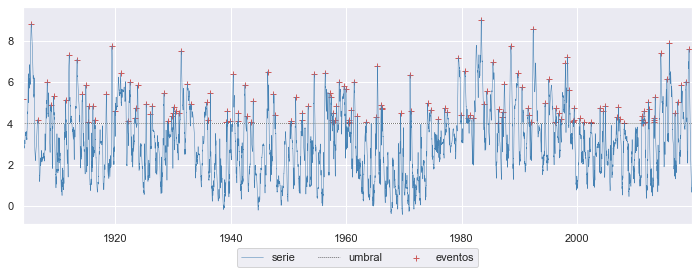

In [16]:
# seleccionar eventos
eventos = potN.select_events(thr)

print('umbral = {0:.2f}\tnº eventos = {1}'.format(thr, len(eventos)))

### Distribución del número anual de eventos

El número de excedencias ocurridas por año es una variable discreta que sigue, habitualmente, una <font color='steelblue'>__distribución de Poisson__</font>, cuya función de probabilidad de masa y sus tres primeros momentos son:
$$P(m = k)=\frac{\mu^k}{k!}e^{-\mu}\;\;\;\;\;k=0,1,2,\ldots$$
$$E(m) = E = \mu$$
$$var(m) = V = \mu$$
$$\mu_3=\mu$$
donde $k>=0$ es el número de ocurrencias del evento, y $\mu$ (positivo), el parámetro de la función, representa el número de veces que se espera que ocurra el fenómeno durante un intervalo dado (habitualmente 1 año).

Si la media es superior a la varianza de la distribución Poisson ajustada, se ha de usar la <font color='steelblue'>distribución binomial</font>. Si la media fuera menor que la varianza, se ha de usar la <font color='steelblue'>distribución binomial negativa</font>.

El ajuste de la distribución discreta se hace a través de la función `fitDis` de la clase `POT` anteriormente declarada.

mu = 1.361
E(m) = 1.361	var(m) = 1.361	mu3 = 0.857
La distribución Poisson es adecuada para el nº anual de eventos
mu = 1.361


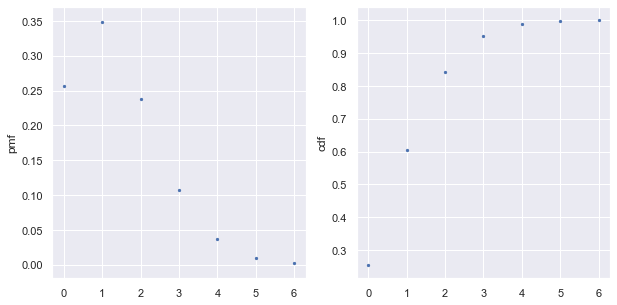

In [18]:
# ajustar distribución discreta
mu = potN.fitDis()
print('mu = {0:.3f}'.format(mu))

### Distribución de la magnitud de los eventos
El análisis se hace sobre la serie de eventos extremos, a cuya magnitud ha de restarse el umbral definido en el primer paso: 
$$y'=y-thr$$

Lo habitual es ajustar esta serie de magnitud de excedencia a una <font color='steelblue'>__distribución exponencial__</font> o a una <font color='steelblue'>distribución generalizada de Pareto</font>. Se podrían utilizar también la log-normal, la Weibull o la ¿GL?. La CDF (_cumulative distribution function_) de la exponencial y sus dos primeros momentos son:
$$G_Y(y)=1-y\exp(-\frac{y}{\beta})>=0$$
$$E(y)=E=\beta$$
$$var(y)=V=\beta^2$$

El ajuste de la distribución continua se hace a través de la función `fitCon` de la clase `POT` anteriormente declarada.

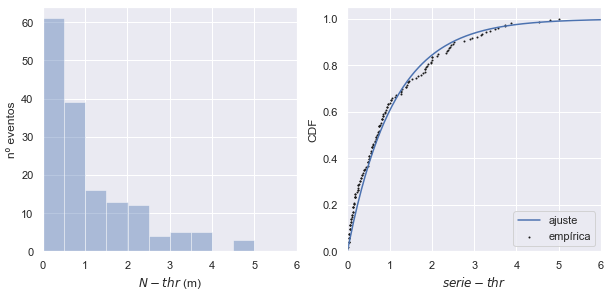

In [19]:
# ajustar la distribución continua
parsExpon = potN.fitCon(thr)

### Definición de la distribución mixta (Poisson + exponencial)
#### <font color='steelblue'>CDF: función de distribución acumulada</font>
La combinación de la distribución continua de la magnitud de las excedencias (exponencial) con la distribución discreta del nº anual de excedencias (Poisson) da como resultado la siguiente función de distribución acumulada:
$$F_X(x)=\sum_{k=0}^{\infty}P(m=k)[G_y(y)]^k$$
o en otra nomenclatura:
$$CDF_{mix}=\sum_{k=0}^{\infty}PMF_{poi}(k)\cdot CDF_{exp}(y)^k$$

El cálculo de la función de distribución acumulada se implementa en la función `cdf` de la clase `POT` anteriormente declarada.

#### <font color='steelblue'>PDF: fundión de densidad de probabilidad</font>
La derivada de la CDF es la función de densidad de probabilidad de la distribución mixta (Poisson + exponencial):
$$PDF_{mix}=\frac{\partial CDF_{mix}}{\partial x}=\sum_{k=0}^{\infty}PMF_{poi}(k)\cdot k\cdot CDF_{exp}(y)^{k-1}\frac{\partial CDF_{exp}(y)}{\partial x}=$$
$$=\sum_{k=0}^{\infty}P(m=k)\cdot k\cdot G_y(y)^{k-1}PDF_{exp}(y)$$
puesto que:
$$\frac{\partial CDF_{exp}(y)}{\partial x}=\frac{\partial CDF_{exp}(y)}{\partial y}\frac{\partial y}{\partial x}=\frac{\partial CDF_{exp}(y)}{\partial y}\frac{\partial (x-thr)}{\partial x}=PDF_{exp}(y)\cdot 1$$

El cálculo de la función de densidad se implementa en la función `pdf` de la clase `POT` anteriormente declarada.

#### <font color='steelblue'>CDF invertida</font>
Para obtener el cuantil de la variable asociado a una probabilidad de excedencia, se ha de invertir la CDF. Es decir, despejar de la ecuación de la CDF la $x$, conocida la probabilidad de excedencia $q$:
$$CDF_{mix}=\sum_{k=0}^{k_{max}}PMF_{Poi}(k)\cdot CDF_{exp}(y)^k=q$$
$$PMF_{poi}(k_{max})\cdot CDF_{exp}(y)^{k_{max}}+\ldots+PMF_{poi}(2)\cdot CDF_{exp}(y)^2+PMF_{poi}(1)\cdot CDF_{exp}(y)+PMF_{poi}(0)=q$$
$$p_{max}\cdot x^{k_{max}}+\ldots+p_2\cdot x^2+p_1\cdot x+p_0-q=0$$

donde:
$$p_i = PMF_{poi}(i);\;\;\;\;\;\;x=CDF_{exp}(y)$$

El cálculo de los cuantiles se implementa en la función `ppf` de la clase `POT` anteriormente declarada.

#### <font color='steelblue'>Aplicación al ejemplo</font>

In [22]:
# calcular cdf
xs = np.linspace(thr, 12, 200)
cdfPOT = potN.cdf(xs, thr)

In [23]:
# calcular pdf
pdfPOT = potN.pdf(xs, thr)

C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: divide by zero encountered in reciprocal
C:\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:188: RuntimeWarning: invalid value encountered in multiply


In [24]:
# calcular cuantiles
epsilon = 1e-4
qs = np.linspace(stats.poisson.pmf(0, mu) + epsilon, 1-epsilon, 200)
xsPOT = potN.ppf(qs, thr)

In [27]:
# valor para un retorno de 100 años-> cdf = 0.99
Tr = 100
N100_pot = potN.ppf([1 - 1 / Tr], thr)[0]
print('N(Tr=100) = {0:.2f} m'.format(N100_pot))

N(Tr=100) = 9.29 m


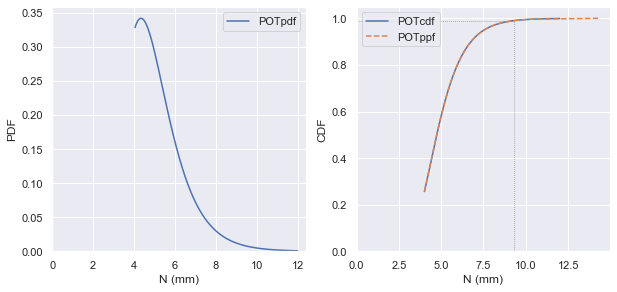

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4.5))
# PDF
ax[0].plot(xs, pdfPOT, label='POTpdf')
ax[0].set(xlim=(0), xlabel=('N (mm)'), ylim=(0), ylabel='PDF')
ax[0].legend();
# CDF
ax[1].plot(xs, cdfPOT, label='POTcdf')
ax[1].plot(xsPOT, qs, ls='--', label='POTppf')
ax[1].hlines(1 - 1 / Tr, 0, N100_pot, lw=.75, ls=':', color='gray')
ax[1].vlines(N100_pot, 0, 1 - 1 / Tr, lw=.75, ls=':', color='gray')
ax[1].set(xlim=(0), xlabel=('N (mm)'), ylim=(0), ylabel='CDF')
ax[1].legend();